Binary classification between subjects with ICD10 cat 10 and those whithout!

### \\\ Currently used ///

Based on copy 3

In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import glob
import h5py

/home/fabiane/anaconda2/envs/mort1/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
import os
import sys
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# pytorch
import torch
import torch.nn as nn
from torch.nn import Module
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, random_split

# sklearn functions
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, KFold, GroupShuffleSplit

# load functions from nitorch
sys.path.insert(0,"/analysis/fabiane/phd/nitorch/")
from nitorch.data import load_nifti
from nitorch.transforms import  ToTensor, SagittalTranslate, SagittalFlip, \
                                AxialTranslate, normalization_factors, Normalize, \
                                IntensityRescale
from nitorch.callbacks import EarlyStopping, ModelCheckpoint
from nitorch.trainer import Trainer
from nitorch.initialization import weights_init
from nitorch.metrics import balanced_accuracy, sensitivity, specificity
from nitorch.utils import count_parameters

In [5]:
torch.__version__

'1.0.0'

In [6]:
# use multiple GPUs
gpu = 3
multi_gpus = None#[0, 1, 2]
b = 12
zero_one_normalize = False
dtype = np.float64

In [7]:
# load mask
mask = None

In [8]:
table = "/analysis/ritter/projects/UKbiobank/Eitel_ICD/tables/participants_transMRI_T1-ICD10_G_binary-under.csv"

In [9]:
# load dataset and show first 5 rows
df = pd.read_csv(table)
df.head()

,Unnamed: 0,PTID,file_path,T2,Encoded anonymised participant ID,T1 structural brain images - NIFTI Index: 2.0,T2 FLAIR structural brain images - NIFTI Index: 2.0,Functional brain images - task - NIFTI Index: 2.0,Sex,ICD10_F_cat,...,Illness2Years2,MoodSwings_diff,Sensitivity_diff,Nervous_diff,Worrier_diff,TenseHighlyStung_diff,Loneliness_diff,RiskTaking_diff,Happiness_diff,FamilyRelation_diff
0,0,1100042,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1100042,20252_2_0,20253_2_0,20249_2_0,Female,[],...,0None,0YY,0YY,1NN,0YY,1NN,1NN,1NN,9Na,9Na
1,1,1100675,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1100675,20252_2_0,20253_2_0,20249_2_0,Female,[],...,0None,1NN,9else,1NN,0YY,9else,1NN,9else,9Na,9Na
2,2,1180478,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1180478,20252_2_0,20253_2_0,20249_2_0,Female,[],...,0None,0YY,0YY,1NN,2YN,0YY,1NN,0YY,9Na,9Na
3,3,1112124,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1112124,20252_2_0,20253_2_0,20249_2_0,Male,[],...,0None,9else,0YY,0YY,0YY,9else,1NN,1NN,9Na,9Na
4,4,1148079,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1148079,20252_2_0,20253_2_0,20249_2_0,Female,[],...,3SitY,3NY,0YY,3NY,0YY,3NY,1NN,1NN,9Na,9Na


In [10]:
# shuffle the dataset
df = df.sample(frac=0.2, random_state=23)
df.head()

,Unnamed: 0,PTID,file_path,T2,Encoded anonymised participant ID,T1 structural brain images - NIFTI Index: 2.0,T2 FLAIR structural brain images - NIFTI Index: 2.0,Functional brain images - task - NIFTI Index: 2.0,Sex,ICD10_F_cat,...,Illness2Years2,MoodSwings_diff,Sensitivity_diff,Nervous_diff,Worrier_diff,TenseHighlyStung_diff,Loneliness_diff,RiskTaking_diff,Happiness_diff,FamilyRelation_diff
791,791,1109592,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1109592,20252_2_0,20253_2_0,20249_2_0,Female,[],...,0None,1NN,3NY,1NN,0YY,1NN,1NN,3NY,MH.VH,VH.VH
1705,1705,1197086,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1197086,20252_2_0,20253_2_0,20249_2_0,Male,[],...,0None,0YY,0YY,9else,2YN,3NY,0YY,1NN,9Na,9Na
167,167,1092621,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1092621,20252_2_0,20253_2_0,20249_2_0,Female,[],...,"4SitR,5DocR",2YN,1NN,1NN,1NN,1NN,3NY,1NN,9Na,9Na
331,331,1037619,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1037619,20252_2_0,20253_2_0,20249_2_0,Male,[],...,0None,2YN,0YY,3NY,3NY,1NN,1NN,0YY,9Na,9Na
651,651,1161652,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1161652,20252_2_0,20253_2_0,20249_2_0,Male,[],...,0None,3NY,3NY,1NN,0YY,1NN,3NY,2YN,9Na,9Na


In [11]:
class UKBGDataset(Dataset):
    def __init__(self, dataframe, transform=None, mask=None, z_factor=None):
        self.df = dataframe
        self.transform = transform
        self.mask = mask
        self.z_factor = z_factor
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        if isinstance(idx, torch.FloatTensor):
            idx = idx.item()
        idx = int(idx)
        
        path = self.df.iloc[idx]['file_path']
        image = load_nifti(path, mask=self.mask, z_factor=self.z_factor)
        #label = self.df.iloc[idx]['ICD10_G_bool']
        #label = torch.FloatTensor([int(label)])
        
        label = self.df.iloc[idx]['Sex']
        label = torch.FloatTensor([int(label == "Male")])
        
        if self.transform:
            image = self.transform(image)
        
        sample = {
            "image" : image,
            "label" : label
         }
        return sample

In [12]:
augmentations = [SagittalFlip()]

In [13]:
intensity = IntensityRescale(masked=False)
input_trans = transforms.Compose(augmentations + [intensity, ToTensor()])
#input_trans = transforms.Compose([ToTensor()])

In [14]:
ukb_data = UKBGDataset(df, transform=input_trans, mask=mask)#, z_factor=0.5)

In [15]:
len(ukb_data)

371

In [16]:
# split train/test
train_df = df.sample(frac=0.8, random_state=32)
test_df = df[~df["PTID"].isin(train_df["PTID"])]
print(len(test_df))

74


In [17]:
sample = ukb_data[3]
img = sample["image"]

In [18]:
img.shape

torch.Size([1, 182, 218, 182])

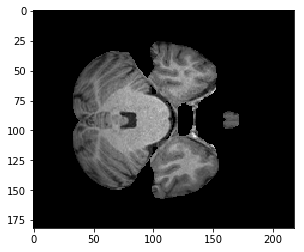

In [19]:
plt.imshow(img[0][:,:,40], cmap='gray')

In [20]:
sample["label"]

tensor([1.])

# Define the classifier

In [21]:
class PatchIndividualFilters3D(Module):
    def __init__(self, input_dim, filter_shape, patch_shape, num_local_filter_in, num_local_filter_out, debug=0):
        super(PatchIndividualFilters3D, self).__init__()
        self.input_dim = input_dim  # expects it to be a 3D vector
        self.filter_shape = filter_shape
        self.patch_shape = patch_shape
        self.num_local_filter_out = num_local_filter_out
        self.num_local_filter_in = num_local_filter_in

        # calc padding and num_patches
        self.padding_dim = [0] * len(self.input_dim) * 2
        # initialize all local convs with weight & co
        self.num_patches, self.num_patches_per_dim = self.calc_pad_dim_num_patches()

        self.conv_dict = {}
        for patch in range(self.num_patches):
            # initialize convolution object
            self.add_module("conv_{}".format(patch),
                            nn.Conv3d(self.num_local_filter_in, self.num_local_filter_out, self.filter_shape, stride=1))
            # initialize activation object
            self.add_module("activ_{}".format(patch),
                            nn.ELU())
            

        self.grads = {}
        self.debug = debug

    def save_grad(self, name):

        def hook(grad):
            self.grads[name] = grad

        return hook

    def calc_pad_dim_num_patches(self):
        # initialize
        num_patches = 1
        num_patches_per_dim = [0] * len(self.input_dim)

        # check if patch_shape fits input dimension
        for idx, dim in enumerate(self.patch_shape):
            tmp_remain = self.input_dim[idx] % dim
            tmp_division = self.input_dim[idx] // dim
            if tmp_remain != 0:
                # how much we need to add sch that patch_shape fits perfectly
                self.padding_dim[idx * 2] = dim - tmp_remain
                tmp_division += 1
            num_patches_per_dim[idx] = tmp_division
            num_patches = num_patches * tmp_division
        return num_patches, num_patches_per_dim

    def pad_to_batch_size(self, input):
        # expects input to be a 5D vector!

        # pad input
        if sum(self.padding_dim):
            # add batch and channel dimension, each twice, to padding dim
            pad_dim = [0, 0, 0, 0] + self.padding_dim

            # use constant pad (caution: last dimension first!)
            input = torch.nn.functional.pad(input, pad_dim[::-1], mode='constant', value=0)

        if self.debug:
            input.register_hook(self.save_grad("post_padding"))

        return input

    def split_5d(self, input):
        # get batch size of input
        bs = input.shape[0]
        # initialize
        splits = []
        # loop over batch and filter and split each "input"
        for batch in range(bs):
            splits_filter = []
            for filter in range(self.num_local_filter_in):
                feature_map_in = input[batch, filter]
                # get chunks back from feature map ("input")
                t = self.get_chunks(feature_map_in)
                # append chunk dimension
                t = [torch.unsqueeze(x, 0) for x in t]
                # cat along chunk dimension
                t = torch.cat(t, 0)
                # add to filter list
                splits_filter += [t]
            # append filter dimension
            splits_filter = [torch.unsqueeze(x, 0) for x in splits_filter]
            # cat along filter dimension
            splits_filter = torch.cat(splits_filter, 0)
            splits += [splits_filter]
        # append batch dimension
        splits = [torch.unsqueeze(x, 0) for x in splits]
        # finally cat along that dimension
        splits = torch.cat(splits, 0)

        if self.debug:
            input.register_hook(self.save_grad("post_reshape"))

        return splits, bs  # a 6D vector

    def get_chunks(self, ddd_input):
        ddd_input_shape = ddd_input.shape
        tns = [ddd_input]
        # for every dimension in 3d input we split according to dimension and number of desired patches
        for id, dim in enumerate(ddd_input_shape):
            tns_tmp = []
            for tnsr in tns:
                # determine how to split the tensor.
                # Example:
                # dimension is 4: 2 batches desired in that dimension -> split dimension in [2,2]
                # dimension is 4: 4 batches desired in that dimension -> split dimension in [1,1,1,1]
                dim_x_split_size = [int(dim / self.num_patches_per_dim[id])] * self.num_patches_per_dim[id]
                # print("dim: " + str(dim))
                # print("num_patches: " + str(self.num_patches_per_dim))
                # print("dim_split_size: " + str(dim_x_split_size))
                tmp = torch.split(tnsr, dim_x_split_size, id)
                tns_tmp += list(tmp)
            tns = tns_tmp
        return tns

    def call_conv(self, idx, patch):

        if self.debug:
            patch.register_hook(self.save_grad("pre_convol_{}".format(idx)))

        # apply convolution
        c_res = getattr(self, "conv_{}".format(idx))(patch)
        # apply activation
        c_res = getattr(self, "activ_{}".format(idx))(c_res)

        if self.debug:
            c_res.register_hook(self.save_grad("post_conv_{}".format(idx)))

        # add 6th dimension at 2. place for later cat
        c_res = c_res.unsqueeze(2)

        if self.debug:
            c_res.register_hook(self.save_grad("post_usqz_c_{}".format(idx)))

        return c_res

    def forward(self, input):

        # set hook to save gradient in debug mode
        if self.debug:
            input.register_hook(self.save_grad("backward_out"))

        # do reshape here!
        input = self.pad_to_batch_size(input)

        # reshape
        input, bs = self.split_5d(input)

        patch_out = []
        for idx in range(self.num_patches):
            # get patch
            patch = input[:, :, idx]  # get each patch (3nd Dimension of 6D vector)
            # do separate convolutions with each 5D vector!
            patch_out += [self.call_conv(idx, patch)]

        # concat to get 6D vector back
        out = torch.cat(patch_out, dim=2)

        # # put together
        # f_out = []
        # feature_out_dim = out.shape[-3:]
        # for filter in range(self.num_local_filter_out):
        #     filter_patch = []
        #     for patch in range(self.num_patches):
        #         y = out[patch, :, filter]
        #         filter_patch.append(y)
        #     z = torch.cat(filter_patch)
        #     z = z.view((bs,) + tuple([x * self.num_patches_per_dim[id] for id, x in enumerate(feature_out_dim)]))
        #     f_out.append(z)
        # out = torch.cat(f_out).unsqueeze(0)
        # out = out.view((bs, self.num_local_filter_out) + tuple([x * self.num_patches_per_dim[id] for id, x in enumerate(feature_out_dim)]))

        if self.debug:
            out.register_hook(self.save_grad("backward_in"))

        return out

In [22]:
class SixtyFourNet(nn.Module):
    def __init__(self, drp_rate=0.3):
        super(SixtyFourNet, self).__init__()
        self.drp_rate = drp_rate
        self.drop = nn.Dropout3d(p=self.drp_rate)
        self.Conv_1 = nn.Conv3d(1, 8, kernel_size=3, stride=1, padding=0)
        self.pool_1 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)
        self.Conv_2 = nn.Conv3d(8, 16, kernel_size=3, stride=1, padding=0)
        self.pool_2 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)
        self.Conv_3 = nn.Conv3d(16, 32, kernel_size=3, stride=1, padding=0)
        self.Conv_4 = nn.Conv3d(32, 64, kernel_size=3, stride=1, padding=0)
        self.pool_4 = nn.MaxPool3d(kernel_size=4, stride=3, padding=0)

        self.pif = PatchIndividualFilters3D([15,19,15],
                                            filter_shape=(3,3,3),
                                            patch_shape=(5,5,5),
                                            num_local_filter_in=64,
                                            num_local_filter_out=8,
                                            debug=False)

        # 4, 64, 1, 2, 1
        self.classifier_scratch = nn.Sequential(
            nn.Linear(7776, 100),
            nn.Linear(100, 1)
        )

    def encode(self, x, print_size=False):
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_1(x))
        h = self.drop(self.pool_1(x))
        x = F.elu(self.Conv_2(h))
        if print_size:
            print(x.shape)
        h = self.drop(self.pool_2(x))
        x = F.elu(self.Conv_3(h))
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_4(x))
        if print_size:
            print(x.shape)
        #h = F.dropout3d(self.pool_4(x), p=self.drp_rate)
        #if print_size:
        #    print(h.shape)
    
        h = self.pif(x)
    
        return h

    def forward(self, x):
        print_size = False
        x = self.encode(x, print_size=print_size)
        x = self.flatten(x)
        x = self.classifier_scratch(x)
        return x
    
    def flatten(self, x):
        return x.view(x.size(0), -1)

In [23]:
if multi_gpus is None:
    net = SixtyFourNet().cuda(gpu)
else:
    net = torch.nn.DataParallel(SixtyFourNet(), device_ids=multi_gpus).cuda(gpu)

In [24]:
print("Trainable model parameters: {}".format(count_parameters(net)))

Trainable model parameters: 1348665


# Training

In [25]:
def run(
    net,
    data,
    shape,
    callbacks=[],
    augmentations=[],
    masked=False,
    metrics=[],
    k_folds=None,
    b=4,
    num_epochs=35,
    retain_metric=None
):      
   
    fold_metric = []
    models = []
    fold = 0
    initial_prepend = None
    
    #for train_idx, val_idx in kf.split(data):#, df["label"]):
    for trial in range(10):
        print("Starting trial {}".format(trial))

        # add current fold number to model checkpoint path
        if callbacks is not None:
            for idx, callback in enumerate(callbacks):
                if isinstance(callback, ModelCheckpoint):
                    if initial_prepend is None:
                        initial_prepend = callbacks[idx].prepend
                    callbacks[idx].prepend = initial_prepend + "cv_fold_{}_".format(fold)
        fold += 1

        # restart model
        del net
        net = SixtyFourNet().cuda(gpu)
        
        # reset hyperparameters
        lr = 1e-5
        wd = 1e-4
        criterion = nn.BCEWithLogitsLoss().cuda(gpu)
        optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
        #optimizer = optim.SGD(net.parameters(), lr=lr, weight_decay=wd, momentum=True)
        
        #sched = optim.lr_scheduler.StepLR(optimizer, gamma=0.1, step_size=12)
        #sched = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.1, patience=5)
        
        # split train/validation
        train_df = data.sample(frac=0.8, random_state=32)
        val_df = data[~data["PTID"].isin(train_df["PTID"])]

        if zero_one_normalize:
            intensity = IntensityRescale()
            ukb_data_train = UKBGDataset(train_df, transform=transforms.Compose(augmentations + [intensity, ToTensor()]), mask=mask)
            ukb_data_val = UKBGDataset(val_df, transform=transforms.Compose([intensity, ToTensor()]), mask=mask)
        else:
            ukb_data_train = UKBGDataset(train_df, transform=transforms.Compose(augmentations + [ToTensor()]), mask=mask)
            ukb_data_val = UKBGDataset(val_df, transform=transforms.Compose([ToTensor()]), mask=mask)
        
        train_loader = DataLoader(
            ukb_data_train, batch_size=b, shuffle=True, num_workers=4
        )

        val_loader = DataLoader(
            ukb_data_val, batch_size=2, shuffle=True, num_workers=2
        )

        trainer = Trainer(
            net,
            criterion,
            optimizer,
            metrics=metrics,
            callbacks=callbacks,
            device=gpu,
            #scheduler=sched,
        )
        # train model and store results
        net, report = trainer.train_model(
            train_loader,
            val_loader,
            num_epochs=num_epochs,
            show_train_steps=5,
            show_validation_epochs=1,
        )
        # append validation score of the retain metric
        if isinstance(retain_metric, str):
            fold_metric.append(report["val_metrics"][retain_metric][-1])
        else:
            fold_metric.append(report["val_metrics"][retain_metric.__name__][-1])

        models.append(net)
        print("Finished fold.")

        # visualize result
        trainer.visualize_training(report, metrics)
        trainer.evaluate_model(val_loader, gpu)

    print("################################")
    print("################################")
    print("All accuracies: {}".format(fold_metric))
    return fold_metric, models


In [26]:
num_epochs = 200
min_iters = 3
ignore_epochs = 15
normalize = False
retain_metric = balanced_accuracy
metrics = [accuracy_score, balanced_accuracy]

In [27]:
r = 0

In [28]:
#output_dir = "/analysis/fabiane/models/MS/pretrained/from_keras/pytorch_finetuned/hdf5"
# ModelCheckpoint(path=output_dir,
                             #prepend="repeat_{}".format(r),
                             #store_best=True,
                             #ignore_before=ignore_epochs,
                             #retain_metric=retain_metric),
callbacks = [EarlyStopping(patience=8, ignore_before=ignore_epochs, retain_metric="loss", mode='min')]


Starting trial 0
[0,     5] loss: 1.11396
[0,    10] loss: 1.16441
[0,    15] loss: 1.02797
Time elapsed: 0h:0m:49s
train accuracy_score: 47.90 %
train balanced_accuracy: 47.40 %
val accuracy_score: 49.15 %
val balanced_accuracy: 47.64 %
Val loss: 0.705324
[1,     5] loss: 1.08013
[1,    10] loss: 0.91493
[1,    15] loss: 0.73209
Time elapsed: 0h:1m:51s
train accuracy_score: 51.68 %
train balanced_accuracy: 50.16 %
val accuracy_score: 47.46 %
val balanced_accuracy: 49.31 %
Val loss: 0.722252
[2,     5] loss: 0.88169
[2,    10] loss: 0.96429
[2,    15] loss: 0.75192
Time elapsed: 0h:2m:53s
train accuracy_score: 54.20 %
train balanced_accuracy: 53.19 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.991141
[3,     5] loss: 0.95463
[3,    10] loss: 0.96943
[3,    15] loss: 0.82366
Time elapsed: 0h:3m:56s
train accuracy_score: 58.82 %
train balanced_accuracy: 58.07 %
val accuracy_score: 49.15 %
val balanced_accuracy: 49.88 %
Val loss: 0.688708
[4,     5] loss: 0.8031

[34,     5] loss: 0.64601
[34,    10] loss: 0.61759
[34,    15] loss: 0.57246
Time elapsed: 0h:37m:56s
train accuracy_score: 65.13 %
train balanced_accuracy: 63.39 %
val accuracy_score: 72.88 %
val balanced_accuracy: 74.02 %
Val loss: 0.592908
[35,     5] loss: 0.57153
[35,    10] loss: 0.73122
[35,    15] loss: 0.70719
Time elapsed: 0h:38m:56s
train accuracy_score: 69.75 %
train balanced_accuracy: 68.96 %
val accuracy_score: 61.02 %
val balanced_accuracy: 59.27 %
Val loss: 0.590947
[36,     5] loss: 0.67255
[36,    10] loss: 0.59225
[36,    15] loss: 0.66441
Time elapsed: 0h:39m:55s
train accuracy_score: 62.61 %
train balanced_accuracy: 61.86 %
val accuracy_score: 69.49 %
val balanced_accuracy: 68.20 %
Val loss: 0.576740
[37,     5] loss: 0.56130
[37,    10] loss: 0.75760
[37,    15] loss: 0.79200
Time elapsed: 0h:40m:56s
train accuracy_score: 61.34 %
train balanced_accuracy: 60.86 %
val accuracy_score: 47.46 %
val balanced_accuracy: 49.83 %
Val loss: 0.690066
[38,     5] loss: 0.7617

val accuracy_score: 81.36 %
val balanced_accuracy: 82.09 %
Val loss: 0.531583
[68,     5] loss: 0.50400
[68,    10] loss: 0.54253
[68,    15] loss: 0.79721
Time elapsed: 1h:15m:47s
train accuracy_score: 66.81 %
train balanced_accuracy: 64.99 %
val accuracy_score: 77.97 %
val balanced_accuracy: 78.86 %
Val loss: 0.541808
[69,     5] loss: 0.70292
[69,    10] loss: 0.65500
[69,    15] loss: 0.63118
Time elapsed: 1h:16m:53s
train accuracy_score: 60.08 %
train balanced_accuracy: 59.41 %
val accuracy_score: 76.27 %
val balanced_accuracy: 75.35 %
Val loss: 0.517442
[70,     5] loss: 0.53680
[70,    10] loss: 0.56954
[70,    15] loss: 0.54810
Time elapsed: 1h:18m:2s
train accuracy_score: 73.11 %
train balanced_accuracy: 72.50 %
val accuracy_score: 69.49 %
val balanced_accuracy: 70.79 %
Val loss: 0.567837
[71,     5] loss: 0.64197
[71,    10] loss: 0.56959
[71,    15] loss: 0.51411
Time elapsed: 1h:19m:11s
train accuracy_score: 69.75 %
train balanced_accuracy: 67.81 %
val accuracy_score: 67.80

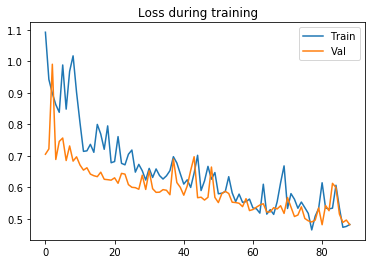

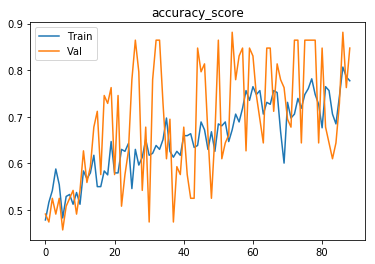

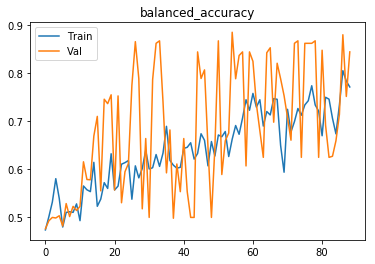

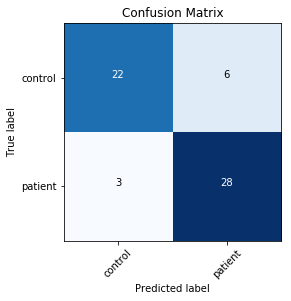

Starting trial 1
[0,     5] loss: 1.40194
[0,    10] loss: 1.16007
[0,    15] loss: 0.91394
Time elapsed: 0h:0m:48s
train accuracy_score: 50.00 %
train balanced_accuracy: 48.68 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 1.126196
[1,     5] loss: 0.85900
[1,    10] loss: 0.95743
[1,    15] loss: 0.88038
Time elapsed: 0h:1m:55s
train accuracy_score: 47.48 %
train balanced_accuracy: 45.19 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.827793
[2,     5] loss: 0.76211
[2,    10] loss: 0.82076
[2,    15] loss: 0.73524
Time elapsed: 0h:2m:58s
train accuracy_score: 56.72 %
train balanced_accuracy: 54.37 %
val accuracy_score: 44.07 %
val balanced_accuracy: 46.43 %
Val loss: 0.749718
[3,     5] loss: 0.78102
[3,    10] loss: 0.76389
[3,    15] loss: 0.99946
Time elapsed: 0h:4m:1s
train accuracy_score: 52.94 %
train balanced_accuracy: 51.61 %
val accuracy_score: 55.93 %
val balanced_accuracy: 54.61 %
Val loss: 0.685278
[4,     5] loss: 0.80849

[34,     5] loss: 0.54920
[34,    10] loss: 0.57119
[34,    15] loss: 0.61156
Time elapsed: 0h:37m:32s
train accuracy_score: 68.91 %
train balanced_accuracy: 66.49 %
val accuracy_score: 71.19 %
val balanced_accuracy: 69.64 %
Val loss: 0.584396
[35,     5] loss: 0.55745
[35,    10] loss: 0.58702
[35,    15] loss: 0.70336
Time elapsed: 0h:38m:42s
train accuracy_score: 71.85 %
train balanced_accuracy: 70.47 %
val accuracy_score: 84.75 %
val balanced_accuracy: 84.10 %
Val loss: 0.560449
[36,     5] loss: 0.63210
[36,    10] loss: 0.56580
[36,    15] loss: 0.61819
Time elapsed: 0h:39m:47s
train accuracy_score: 66.81 %
train balanced_accuracy: 66.37 %
val accuracy_score: 81.36 %
val balanced_accuracy: 80.53 %
Val loss: 0.563563
[37,     5] loss: 0.50184
[37,    10] loss: 0.58697
[37,    15] loss: 0.58559
Time elapsed: 0h:40m:49s
train accuracy_score: 73.11 %
train balanced_accuracy: 71.81 %
val accuracy_score: 57.63 %
val balanced_accuracy: 59.50 %
Val loss: 0.597785
[38,     5] loss: 0.6097

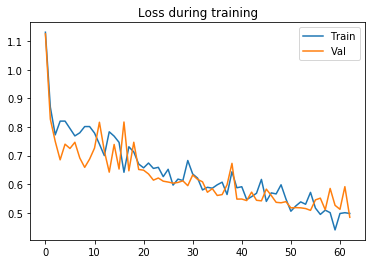

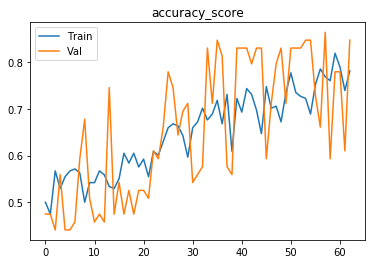

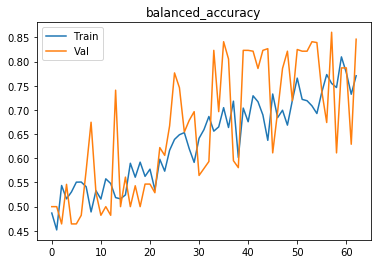

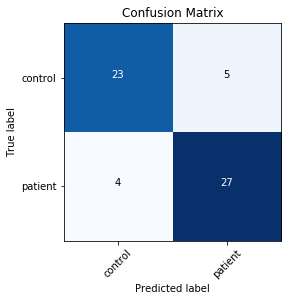

Starting trial 2
[0,     5] loss: 1.76004
[0,    10] loss: 1.37812
[0,    15] loss: 0.86343
Time elapsed: 0h:1m:5s
train accuracy_score: 55.04 %
train balanced_accuracy: 53.47 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.876727
[1,     5] loss: 0.92297
[1,    10] loss: 1.01106
[1,    15] loss: 1.05068
Time elapsed: 0h:2m:20s
train accuracy_score: 53.78 %
train balanced_accuracy: 53.05 %
val accuracy_score: 47.46 %
val balanced_accuracy: 49.83 %
Val loss: 0.747436
[2,     5] loss: 0.73381
[2,    10] loss: 0.88917
[2,    15] loss: 0.87323
Time elapsed: 0h:3m:19s
train accuracy_score: 50.84 %
train balanced_accuracy: 47.81 %
val accuracy_score: 57.63 %
val balanced_accuracy: 56.05 %
Val loss: 0.684134
[3,     5] loss: 0.91267
[3,    10] loss: 0.62903
[3,    15] loss: 0.88767
Time elapsed: 0h:4m:28s
train accuracy_score: 56.72 %
train balanced_accuracy: 56.21 %
val accuracy_score: 54.24 %
val balanced_accuracy: 55.59 %
Val loss: 0.677798
[4,     5] loss: 0.64381

[34,     5] loss: 0.59735
[34,    10] loss: 0.66857
[34,    15] loss: 0.60638
Time elapsed: 0h:37m:6s
train accuracy_score: 63.45 %
train balanced_accuracy: 61.22 %
val accuracy_score: 79.66 %
val balanced_accuracy: 78.92 %
Val loss: 0.573137
[35,     5] loss: 0.54325
[35,    10] loss: 0.52872
[35,    15] loss: 0.61066
Time elapsed: 0h:38m:15s
train accuracy_score: 68.49 %
train balanced_accuracy: 67.16 %
val accuracy_score: 81.36 %
val balanced_accuracy: 81.05 %
Val loss: 0.574104
[36,     5] loss: 0.68379
[36,    10] loss: 0.51972
[36,    15] loss: 0.61278
Time elapsed: 0h:39m:39s
train accuracy_score: 67.65 %
train balanced_accuracy: 65.96 %
val accuracy_score: 74.58 %
val balanced_accuracy: 73.21 %
Val loss: 0.576700
[37,     5] loss: 0.56907
[37,    10] loss: 0.57416
[37,    15] loss: 0.60361
Time elapsed: 0h:40m:38s
train accuracy_score: 70.59 %
train balanced_accuracy: 70.97 %
val accuracy_score: 69.49 %
val balanced_accuracy: 70.10 %
Val loss: 0.573468
[38,     5] loss: 0.68690

val accuracy_score: 71.19 %
val balanced_accuracy: 72.24 %
Val loss: 0.537696
[68,     5] loss: 0.47003
[68,    10] loss: 0.42504
[68,    15] loss: 0.43774
Time elapsed: 1h:12m:54s
train accuracy_score: 78.15 %
train balanced_accuracy: 77.17 %
val accuracy_score: 83.05 %
val balanced_accuracy: 82.14 %
Val loss: 0.504607
[69,     5] loss: 0.44449
[69,    10] loss: 0.48903
[69,    15] loss: 0.45450
Time elapsed: 1h:13m:57s
train accuracy_score: 81.93 %
train balanced_accuracy: 81.54 %
val accuracy_score: 77.97 %
val balanced_accuracy: 78.17 %
Val loss: 0.507600
[70,     5] loss: 0.50751
[70,    10] loss: 0.40954
[70,    15] loss: 0.47635
Time elapsed: 1h:15m:0s
train accuracy_score: 77.31 %
train balanced_accuracy: 76.66 %
val accuracy_score: 81.36 %
val balanced_accuracy: 81.05 %
Val loss: 0.482827
[71,     5] loss: 0.49124
[71,    10] loss: 0.47076
[71,    15] loss: 0.41865
Time elapsed: 1h:16m:4s
train accuracy_score: 81.51 %
train balanced_accuracy: 81.06 %
val accuracy_score: 74.58 

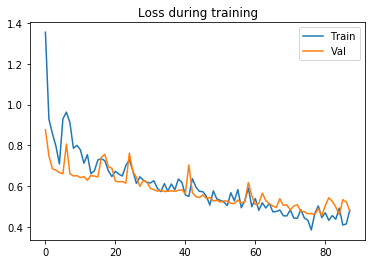

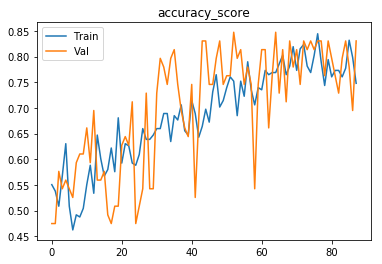

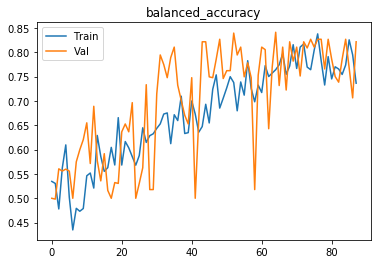

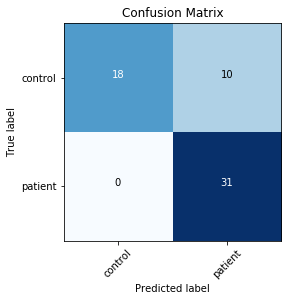

Starting trial 3
[0,     5] loss: 1.40952
[0,    10] loss: 1.19109
[0,    15] loss: 1.27033
Time elapsed: 0h:0m:48s
train accuracy_score: 47.48 %
train balanced_accuracy: 47.38 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.868562
[1,     5] loss: 0.96700
[1,    10] loss: 0.73961
[1,    15] loss: 0.72579
Time elapsed: 0h:1m:52s
train accuracy_score: 60.08 %
train balanced_accuracy: 58.49 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.730335
[2,     5] loss: 0.78191
[2,    10] loss: 0.81205
[2,    15] loss: 0.73543
Time elapsed: 0h:2m:49s
train accuracy_score: 47.48 %
train balanced_accuracy: 46.34 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.772053
[3,     5] loss: 0.88953
[3,    10] loss: 0.88356
[3,    15] loss: 0.85691
Time elapsed: 0h:3m:49s
train accuracy_score: 50.42 %
train balanced_accuracy: 48.13 %
val accuracy_score: 47.46 %
val balanced_accuracy: 49.65 %
Val loss: 0.717355
[4,     5] loss: 0.7171

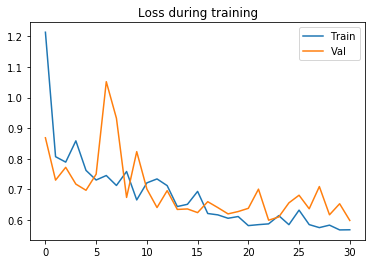

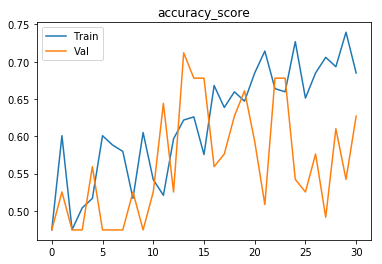

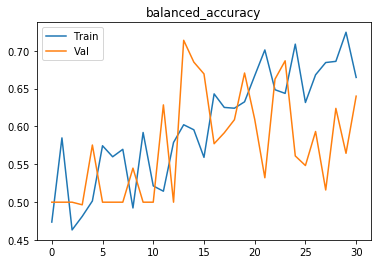

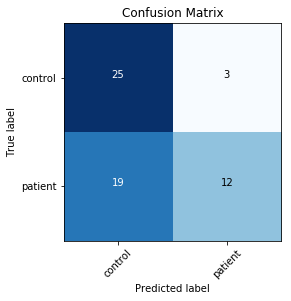

Starting trial 4
[0,     5] loss: 1.79551
[0,    10] loss: 0.84898
[0,    15] loss: 1.05186
Time elapsed: 0h:0m:48s
train accuracy_score: 53.36 %
train balanced_accuracy: 52.33 %
val accuracy_score: 54.24 %
val balanced_accuracy: 51.79 %
Val loss: 0.731975
[1,     5] loss: 0.76279
[1,    10] loss: 0.88621
[1,    15] loss: 0.79934
Time elapsed: 0h:1m:51s
train accuracy_score: 53.78 %
train balanced_accuracy: 51.55 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.770224
[2,     5] loss: 0.93834
[2,    10] loss: 0.66179
[2,    15] loss: 0.88442
Time elapsed: 0h:2m:53s
train accuracy_score: 51.26 %
train balanced_accuracy: 50.02 %
val accuracy_score: 57.63 %
val balanced_accuracy: 58.47 %
Val loss: 0.660775
[3,     5] loss: 0.85299
[3,    10] loss: 0.75787
[3,    15] loss: 0.98708
Time elapsed: 0h:3m:53s
train accuracy_score: 56.72 %
train balanced_accuracy: 55.41 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.752922
[4,     5] loss: 0.8537

[34,     5] loss: 0.54896
[34,    10] loss: 0.57754
[34,    15] loss: 0.50973
Time elapsed: 0h:36m:51s
train accuracy_score: 72.27 %
train balanced_accuracy: 71.41 %
val accuracy_score: 59.32 %
val balanced_accuracy: 57.14 %
Val loss: 0.588068
[35,     5] loss: 0.57068
[35,    10] loss: 0.48227
[35,    15] loss: 0.56858
Time elapsed: 0h:38m:13s
train accuracy_score: 69.75 %
train balanced_accuracy: 68.50 %
val accuracy_score: 81.36 %
val balanced_accuracy: 81.91 %
Val loss: 0.551083
[36,     5] loss: 0.62877
[36,    10] loss: 0.57885
[36,    15] loss: 0.54241
Time elapsed: 0h:39m:28s
train accuracy_score: 69.75 %
train balanced_accuracy: 68.04 %
val accuracy_score: 86.44 %
val balanced_accuracy: 85.89 %
Val loss: 0.539937
[37,     5] loss: 0.55886
[37,    10] loss: 0.50390
[37,    15] loss: 0.56034
Time elapsed: 0h:40m:33s
train accuracy_score: 76.47 %
train balanced_accuracy: 75.12 %
val accuracy_score: 84.75 %
val balanced_accuracy: 84.10 %
Val loss: 0.526865
[38,     5] loss: 0.4756

val accuracy_score: 83.05 %
val balanced_accuracy: 83.35 %
Val loss: 0.451880
[68,     5] loss: 0.36068
[68,    10] loss: 0.41603
[68,    15] loss: 0.33915
Time elapsed: 1h:10m:38s
train accuracy_score: 83.19 %
train balanced_accuracy: 82.42 %
val accuracy_score: 88.14 %
val balanced_accuracy: 87.50 %
Val loss: 0.440354
[69,     5] loss: 0.37351
[69,    10] loss: 0.48141
[69,    15] loss: 0.48834
Time elapsed: 1h:11m:37s
train accuracy_score: 76.47 %
train balanced_accuracy: 75.23 %
val accuracy_score: 84.75 %
val balanced_accuracy: 84.62 %
Val loss: 0.435727
[70,     5] loss: 0.44520
[70,    10] loss: 0.46292
[70,    15] loss: 0.55799
Time elapsed: 1h:12m:35s
train accuracy_score: 80.25 %
train balanced_accuracy: 80.06 %
val accuracy_score: 83.05 %
val balanced_accuracy: 83.01 %
Val loss: 0.446086
[71,     5] loss: 0.39852
[71,    10] loss: 0.42734
[71,    15] loss: 0.42349
Time elapsed: 1h:13m:33s
train accuracy_score: 83.19 %
train balanced_accuracy: 81.85 %
val accuracy_score: 74.5

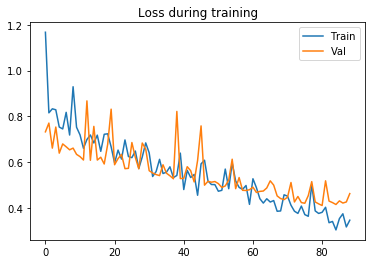

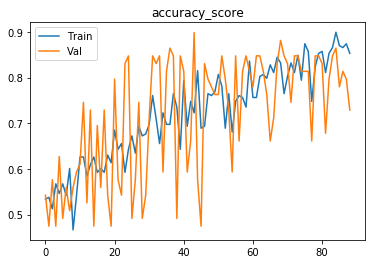

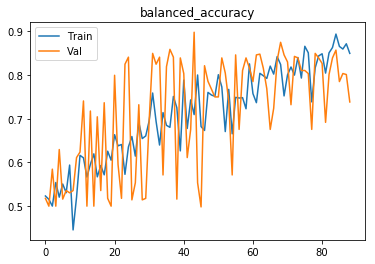

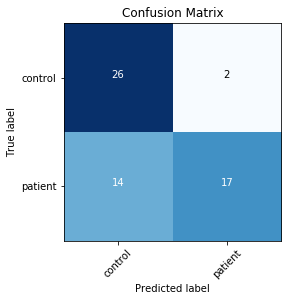

Starting trial 5
[0,     5] loss: 1.71647
[0,    10] loss: 1.39321
[0,    15] loss: 1.07709
Time elapsed: 0h:0m:45s
train accuracy_score: 47.48 %
train balanced_accuracy: 46.34 %
val accuracy_score: 47.46 %
val balanced_accuracy: 49.83 %
Val loss: 0.888493
[1,     5] loss: 1.33486
[1,    10] loss: 1.25278
[1,    15] loss: 1.29419
Time elapsed: 0h:1m:41s
train accuracy_score: 51.68 %
train balanced_accuracy: 49.70 %
val accuracy_score: 57.63 %
val balanced_accuracy: 58.47 %
Val loss: 0.682424
[2,     5] loss: 0.90978
[2,    10] loss: 1.01345
[2,    15] loss: 0.93177
Time elapsed: 0h:2m:39s
train accuracy_score: 52.94 %
train balanced_accuracy: 52.07 %
val accuracy_score: 59.32 %
val balanced_accuracy: 59.74 %
Val loss: 0.666814
[3,     5] loss: 0.85215
[3,    10] loss: 0.97872
[3,    15] loss: 0.91035
Time elapsed: 0h:3m:50s
train accuracy_score: 60.92 %
train balanced_accuracy: 60.03 %
val accuracy_score: 49.15 %
val balanced_accuracy: 46.77 %
Val loss: 0.689577
[4,     5] loss: 0.9299

[34,     5] loss: 0.57800
[34,    10] loss: 0.50379
[34,    15] loss: 0.65984
Time elapsed: 0h:35m:44s
train accuracy_score: 68.49 %
train balanced_accuracy: 68.19 %
val accuracy_score: 61.02 %
val balanced_accuracy: 62.73 %
Val loss: 0.593983
[35,     5] loss: 0.53149
[35,    10] loss: 0.56243
[35,    15] loss: 0.63844
Time elapsed: 0h:36m:42s
train accuracy_score: 69.33 %
train balanced_accuracy: 67.78 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.671728
[36,     5] loss: 0.67721
[36,    10] loss: 0.61671
[36,    15] loss: 0.53951
Time elapsed: 0h:37m:42s
train accuracy_score: 68.91 %
train balanced_accuracy: 68.34 %
val accuracy_score: 74.58 %
val balanced_accuracy: 74.94 %
Val loss: 0.553274
[37,     5] loss: 0.56457
[37,    10] loss: 0.59228
[37,    15] loss: 0.61708
Time elapsed: 0h:38m:43s
train accuracy_score: 69.75 %
train balanced_accuracy: 68.62 %
val accuracy_score: 55.93 %
val balanced_accuracy: 58.06 %
Val loss: 0.604963
[38,     5] loss: 0.6989

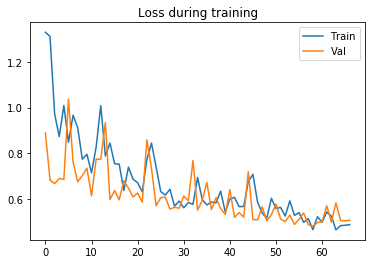

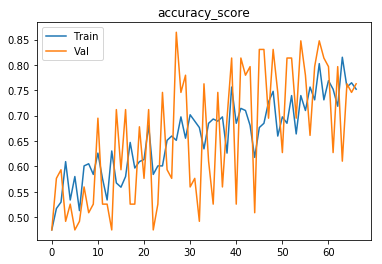

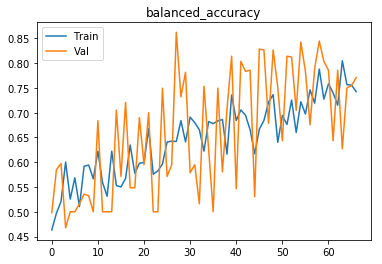

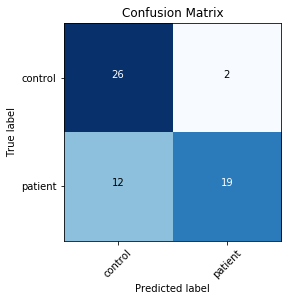

Starting trial 6
[0,     5] loss: 1.32256
[0,    10] loss: 1.42322
[0,    15] loss: 1.11341
Time elapsed: 0h:0m:47s
train accuracy_score: 52.94 %
train balanced_accuracy: 51.38 %
val accuracy_score: 42.37 %
val balanced_accuracy: 42.05 %
Val loss: 0.697362
[1,     5] loss: 1.02871
[1,    10] loss: 0.82019
[1,    15] loss: 0.86735
Time elapsed: 0h:1m:46s
train accuracy_score: 51.26 %
train balanced_accuracy: 50.36 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.918131
[2,     5] loss: 0.91597
[2,    10] loss: 0.92262
[2,    15] loss: 1.20928
Time elapsed: 0h:2m:46s
train accuracy_score: 47.48 %
train balanced_accuracy: 45.76 %
val accuracy_score: 52.54 %
val balanced_accuracy: 51.04 %
Val loss: 0.689530
[3,     5] loss: 0.83435
[3,    10] loss: 0.72632
[3,    15] loss: 0.89594
Time elapsed: 0h:3m:45s
train accuracy_score: 56.72 %
train balanced_accuracy: 55.41 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.775873
[4,     5] loss: 0.9240

val accuracy_score: 69.49 %
val balanced_accuracy: 69.93 %
Val loss: 0.602965
[34,     5] loss: 0.64484
[34,    10] loss: 0.72641
[34,    15] loss: 0.68217
Time elapsed: 0h:34m:29s
train accuracy_score: 63.45 %
train balanced_accuracy: 62.02 %
val accuracy_score: 64.41 %
val balanced_accuracy: 62.50 %
Val loss: 0.628638
[35,     5] loss: 0.63725
[35,    10] loss: 0.67714
[35,    15] loss: 0.62028
Time elapsed: 0h:35m:26s
train accuracy_score: 65.97 %
train balanced_accuracy: 64.48 %
val accuracy_score: 62.71 %
val balanced_accuracy: 60.71 %
Val loss: 0.628499
[36,     5] loss: 0.67603
[36,    10] loss: 0.75708
[36,    15] loss: 0.58256
Time elapsed: 0h:36m:22s
train accuracy_score: 60.92 %
train balanced_accuracy: 60.03 %
val accuracy_score: 59.32 %
val balanced_accuracy: 61.12 %
Val loss: 0.633484
[37,     5] loss: 0.60019
[37,    10] loss: 0.68950
[37,    15] loss: 0.62797
Time elapsed: 0h:37m:19s
train accuracy_score: 65.97 %
train balanced_accuracy: 64.48 %
val accuracy_score: 71.1

Time elapsed: 1h:7m:55s
train accuracy_score: 76.89 %
train balanced_accuracy: 76.06 %
val accuracy_score: 81.36 %
val balanced_accuracy: 81.05 %
Val loss: 0.534972
[68,     5] loss: 0.53485
[68,    10] loss: 0.50766
[68,    15] loss: 0.50704
Time elapsed: 1h:8m:55s
train accuracy_score: 73.95 %
train balanced_accuracy: 73.01 %
val accuracy_score: 67.80 %
val balanced_accuracy: 68.49 %
Val loss: 0.541344
[69,     5] loss: 0.43885
[69,    10] loss: 0.50263
[69,    15] loss: 0.54924
Time elapsed: 1h:9m:54s
train accuracy_score: 76.47 %
train balanced_accuracy: 75.58 %
val accuracy_score: 67.80 %
val balanced_accuracy: 68.49 %
Val loss: 0.537287
[70,     5] loss: 0.48870
[70,    10] loss: 0.43904
[70,    15] loss: 0.53715
Time elapsed: 1h:10m:55s
train accuracy_score: 79.41 %
train balanced_accuracy: 78.51 %
val accuracy_score: 77.97 %
val balanced_accuracy: 76.79 %
Val loss: 0.538233
[71,     5] loss: 0.46818
[71,    10] loss: 0.49066
[71,    15] loss: 0.49564
Time elapsed: 1h:11m:53s
tr

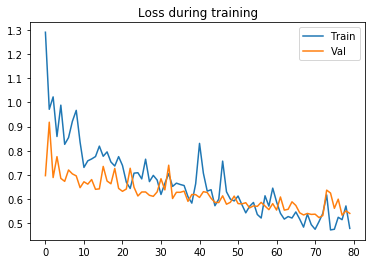

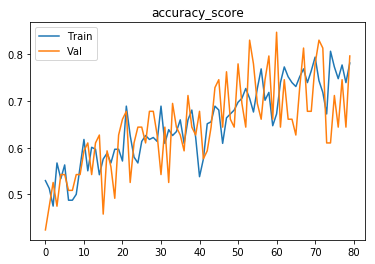

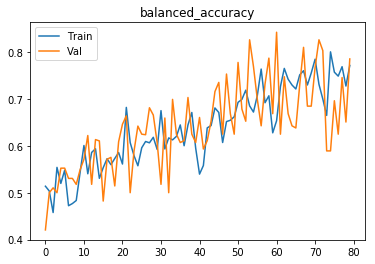

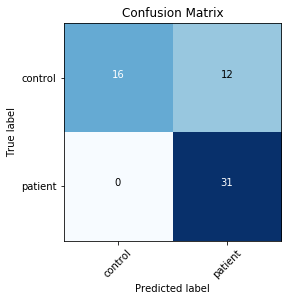

Starting trial 7
[0,     5] loss: 1.50680
[0,    10] loss: 1.21944
[0,    15] loss: 1.08871
Time elapsed: 0h:0m:47s
train accuracy_score: 50.42 %
train balanced_accuracy: 49.85 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.789568
[1,     5] loss: 1.07141
[1,    10] loss: 1.04134
[1,    15] loss: 0.91368
Time elapsed: 0h:1m:47s
train accuracy_score: 46.64 %
train balanced_accuracy: 44.68 %
val accuracy_score: 57.63 %
val balanced_accuracy: 58.12 %
Val loss: 0.683444
[2,     5] loss: 0.79004
[2,    10] loss: 0.74187
[2,    15] loss: 0.84898
Time elapsed: 0h:2m:46s
train accuracy_score: 53.78 %
train balanced_accuracy: 52.82 %
val accuracy_score: 62.71 %
val balanced_accuracy: 63.13 %
Val loss: 0.677253
[3,     5] loss: 0.81709
[3,    10] loss: 0.92898
[3,    15] loss: 0.79316
Time elapsed: 0h:3m:45s
train accuracy_score: 55.04 %
train balanced_accuracy: 52.78 %
val accuracy_score: 50.85 %
val balanced_accuracy: 53.23 %
Val loss: 0.694045
[4,     5] loss: 0.6967

val accuracy_score: 74.58 %
val balanced_accuracy: 73.56 %
Val loss: 0.570487
[34,     5] loss: 0.65068
[34,    10] loss: 0.62264
[34,    15] loss: 0.69681
Time elapsed: 0h:34m:13s
train accuracy_score: 61.76 %
train balanced_accuracy: 61.00 %
val accuracy_score: 66.10 %
val balanced_accuracy: 64.29 %
Val loss: 0.583037
[35,     5] loss: 0.51564
[35,    10] loss: 0.64073
[35,    15] loss: 0.65244
Time elapsed: 0h:35m:14s
train accuracy_score: 67.65 %
train balanced_accuracy: 65.61 %
val accuracy_score: 74.58 %
val balanced_accuracy: 73.73 %
Val loss: 0.566018
[36,     5] loss: 0.66030
[36,    10] loss: 0.49718
[36,    15] loss: 0.68354
Time elapsed: 0h:36m:11s
train accuracy_score: 68.49 %
train balanced_accuracy: 67.16 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.722723
[37,     5] loss: 0.63863
[37,    10] loss: 0.61031
[37,    15] loss: 0.72078
Time elapsed: 0h:37m:9s
train accuracy_score: 62.61 %
train balanced_accuracy: 61.63 %
val accuracy_score: 72.88

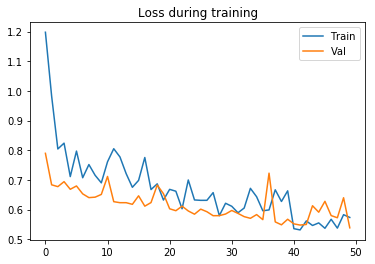

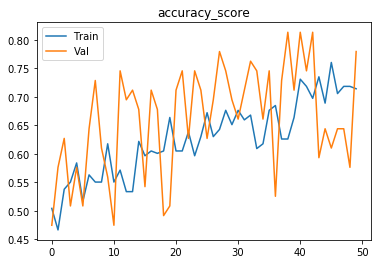

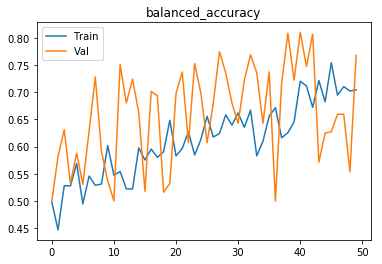

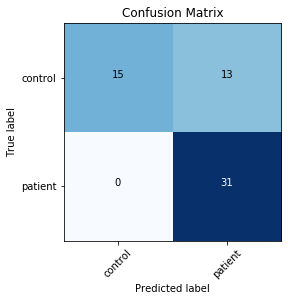

Starting trial 8
[0,     5] loss: 1.17311
[0,    10] loss: 1.33413
[0,    15] loss: 0.89868
Time elapsed: 0h:0m:56s
train accuracy_score: 50.00 %
train balanced_accuracy: 48.68 %
val accuracy_score: 47.46 %
val balanced_accuracy: 45.51 %
Val loss: 0.751404
[1,     5] loss: 1.09198
[1,    10] loss: 1.07036
[1,    15] loss: 0.68567
Time elapsed: 0h:1m:56s
train accuracy_score: 53.36 %
train balanced_accuracy: 51.87 %
val accuracy_score: 49.15 %
val balanced_accuracy: 47.47 %
Val loss: 0.739184
[2,     5] loss: 0.89980
[2,    10] loss: 1.05541
[2,    15] loss: 1.18345
Time elapsed: 0h:2m:57s
train accuracy_score: 50.42 %
train balanced_accuracy: 49.39 %
val accuracy_score: 49.15 %
val balanced_accuracy: 51.44 %
Val loss: 0.808607
[3,     5] loss: 0.88966
[3,    10] loss: 0.78980
[3,    15] loss: 0.77525
Time elapsed: 0h:3m:56s
train accuracy_score: 60.08 %
train balanced_accuracy: 58.83 %
val accuracy_score: 44.07 %
val balanced_accuracy: 45.91 %
Val loss: 0.752605
[4,     5] loss: 0.7668

val accuracy_score: 49.15 %
val balanced_accuracy: 51.61 %
Val loss: 0.740160
[34,     5] loss: 0.56879
[34,    10] loss: 0.57981
[34,    15] loss: 0.59618
Time elapsed: 0h:34m:51s
train accuracy_score: 68.07 %
train balanced_accuracy: 66.90 %
val accuracy_score: 76.27 %
val balanced_accuracy: 75.52 %
Val loss: 0.575952
[35,     5] loss: 0.74487
[35,    10] loss: 0.56201
[35,    15] loss: 0.54137
Time elapsed: 0h:35m:51s
train accuracy_score: 62.61 %
train balanced_accuracy: 61.28 %
val accuracy_score: 62.71 %
val balanced_accuracy: 63.82 %
Val loss: 0.598108
[36,     5] loss: 0.52724
[36,    10] loss: 0.63181
[36,    15] loss: 0.57105
Time elapsed: 0h:36m:50s
train accuracy_score: 67.65 %
train balanced_accuracy: 65.84 %
val accuracy_score: 69.49 %
val balanced_accuracy: 70.10 %
Val loss: 0.581996
[37,     5] loss: 0.62454
[37,    10] loss: 0.54757
[37,    15] loss: 0.52003
Time elapsed: 0h:37m:50s
train accuracy_score: 69.75 %
train balanced_accuracy: 68.27 %
val accuracy_score: 77.9

Time elapsed: 1h:7m:27s
train accuracy_score: 84.03 %
train balanced_accuracy: 83.39 %
val accuracy_score: 79.66 %
val balanced_accuracy: 79.26 %
Val loss: 0.473245
[68,     5] loss: 0.45311
[68,    10] loss: 0.51425
[68,    15] loss: 0.33994
Time elapsed: 1h:8m:26s
train accuracy_score: 80.67 %
train balanced_accuracy: 80.32 %
val accuracy_score: 71.19 %
val balanced_accuracy: 72.06 %
Val loss: 0.531551
[69,     5] loss: 0.40066
[69,    10] loss: 0.40818
[69,    15] loss: 0.48924
Time elapsed: 1h:9m:25s
train accuracy_score: 82.35 %
train balanced_accuracy: 81.91 %
val accuracy_score: 74.58 %
val balanced_accuracy: 74.94 %
Val loss: 0.484082
[70,     5] loss: 0.33782
[70,    10] loss: 0.44163
[70,    15] loss: 0.54667
Time elapsed: 1h:10m:23s
train accuracy_score: 83.19 %
train balanced_accuracy: 82.19 %
val accuracy_score: 76.27 %
val balanced_accuracy: 76.38 %
Val loss: 0.478642
[71,     5] loss: 0.34740
[71,    10] loss: 0.40354
[71,    15] loss: 0.37665
Time elapsed: 1h:11m:24s
tr

[101,     5] loss: 0.30146
[101,    10] loss: 0.28204
[101,    15] loss: 0.23387
Time elapsed: 1h:41m:8s
train accuracy_score: 91.60 %
train balanced_accuracy: 91.33 %
val accuracy_score: 83.05 %
val balanced_accuracy: 82.49 %
Val loss: 0.397373
[102,     5] loss: 0.28965
[102,    10] loss: 0.27462
[102,    15] loss: 0.36811
Time elapsed: 1h:42m:7s
train accuracy_score: 88.24 %
train balanced_accuracy: 87.90 %
val accuracy_score: 76.27 %
val balanced_accuracy: 76.73 %
Val loss: 0.447429
[103,     5] loss: 0.23132
[103,    10] loss: 0.31689
[103,    15] loss: 0.31366
Time elapsed: 1h:43m:24s
train accuracy_score: 87.82 %
train balanced_accuracy: 87.19 %
val accuracy_score: 79.66 %
val balanced_accuracy: 79.95 %
Val loss: 0.412823
[104,     5] loss: 0.23594
[104,    10] loss: 0.29325
[104,    15] loss: 0.33907
Time elapsed: 1h:44m:25s
train accuracy_score: 89.50 %
train balanced_accuracy: 89.36 %
val accuracy_score: 79.66 %
val balanced_accuracy: 79.95 %
Val loss: 0.429702
[105,     5] l

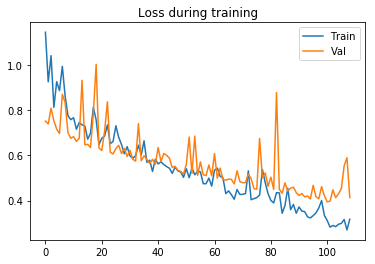

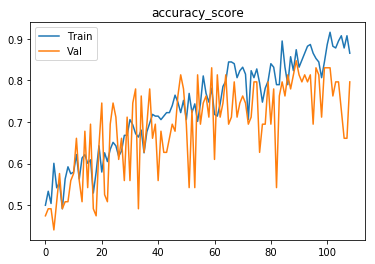

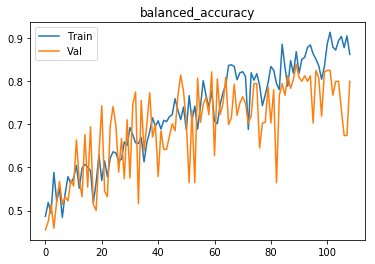

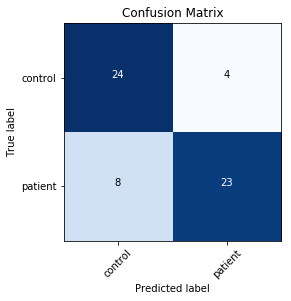

Starting trial 9
[0,     5] loss: 2.60108
[0,    10] loss: 1.42200
[0,    15] loss: 2.45665
Time elapsed: 0h:0m:46s
train accuracy_score: 50.00 %
train balanced_accuracy: 47.99 %
val accuracy_score: 50.85 %
val balanced_accuracy: 48.39 %
Val loss: 0.814631
[1,     5] loss: 1.29328
[1,    10] loss: 1.17253
[1,    15] loss: 1.29829
Time elapsed: 0h:1m:44s
train accuracy_score: 51.68 %
train balanced_accuracy: 51.19 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.17 %
Val loss: 0.720049
[2,     5] loss: 1.20576
[2,    10] loss: 1.11507
[2,    15] loss: 0.94166
Time elapsed: 0h:2m:43s
train accuracy_score: 50.42 %
train balanced_accuracy: 50.08 %
val accuracy_score: 55.93 %
val balanced_accuracy: 53.74 %
Val loss: 0.689463
[3,     5] loss: 1.01865
[3,    10] loss: 0.73739
[3,    15] loss: 0.92139
Time elapsed: 0h:3m:44s
train accuracy_score: 53.78 %
train balanced_accuracy: 52.36 %
val accuracy_score: 50.85 %
val balanced_accuracy: 53.05 %
Val loss: 0.724810
[4,     5] loss: 0.7731

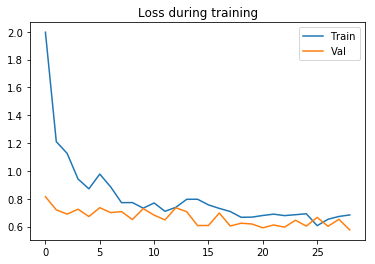

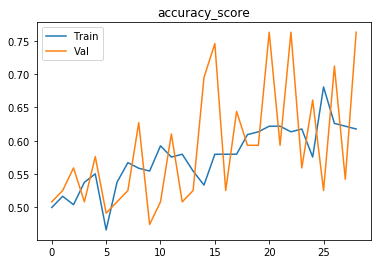

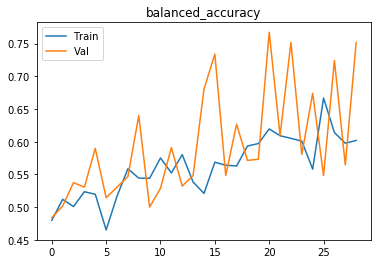

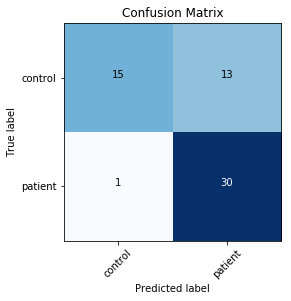

################################
################################
All accuracies: [0.8444700460829493, 0.8461981566820276, 0.8214285714285714, 0.6399769585253456, 0.738479262672811, 0.7707373271889403, 0.7857142857142857, 0.7678571428571428, 0.7995391705069124, 0.7517281105990784]
0.7766129032258065
0.05737385023675333


In [29]:
fold_metric, models = run(net=net, data=train_df,
                  k_folds=-1,
                  callbacks=callbacks,
                  shape=-1,
                  masked=False,
                  metrics=metrics,
                  num_epochs=num_epochs,
                  retain_metric=retain_metric,
                  b=b
                 )

print(np.mean(fold_metric))
print(np.std(fold_metric))

In [30]:
5/0

ZeroDivisionError: division by zero

In [ ]:
output_dir = "/analysis/ritter/projects/Methods/Eitel_local_filter/models"

In [ ]:
def save_model(model, full_path):
    print("Writing model to disk...")
    model = model.cpu()
    torch.save(model.state_dict(), full_path)

In [ ]:
save_models = False

In [ ]:
if save_models:
    for i, model in enumerate(models):
        model_dir = os.path.join(output_dir, "adni_baseline_499k_augmentation_copy1_84_acc_trial_{}.h5".format(i))
        save_model(model, model_dir)

# Start inference

In [31]:
if zero_one_normalize:
    ukb_data_test = UKBGDataset(test_df, transform=transforms.Compose([intensity, ToTensor()]), mask=mask)
else:
    ukb_data_test = UKBGDataset(test_df, transform=transforms.Compose([ToTensor()]), mask=mask)
            
test_loader = DataLoader(
            ukb_data_test, batch_size=1, num_workers=1, shuffle=False
)

In [32]:
metrics = []
lr = 1e-5
wd = 1e-3
criterion = nn.BCEWithLogitsLoss().cuda(gpu)
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
    
for fold, model in enumerate(models):
    print("Fold {}".format(fold))

    all_preds = []
    all_labels = []
    
    net = model.cuda(gpu)
    net.eval()
    with torch.no_grad():
        for sample in test_loader:
            img = sample["image"]
            label = sample["label"]

            img = img.to(torch.device("cuda:" + str(gpu)))

            output = net.forward(img)
            pred = torch.sigmoid(output) >= 0.5
            all_preds.append(pred.cpu().numpy().item())
            all_labels.append(label.numpy().item())
    
    #print(all_preds)
    #print(all_labels)
    balanced_acc = balanced_accuracy(all_labels, all_preds)
    print(balanced_acc)
    '''trainer = Trainer(
                net,
                criterion,
                optimizer,
                scheduler=None,
                metrics=metrics,
                callbacks=None,
                device=gpu,
                prediction_type="binary"
            )
    computed_metrics = trainer.evaluate_model(test_loader, metrics=[balanced_accuracy])'''
    net.train()
    metrics.append(balanced_acc)
print("######## Final results ########")
metrics_df = pd.DataFrame(metrics)
print(metrics_df)
print("Balanced accuracy mean {:.2f} %".format(np.mean(metrics_df[0])*100))


Fold 0
0.8358974358974359
Fold 1
0.8600732600732601
Fold 2
0.8703296703296703
Fold 3
0.6857142857142857
Fold 4
0.7571428571428571
Fold 5
0.6571428571428571
Fold 6
0.8289377289377289
Fold 7
0.8146520146520146
Fold 8
0.7857142857142857
Fold 9
0.715018315018315
######## Final results ########
          0
0  0.835897
1  0.860073
2  0.870330
3  0.685714
4  0.757143
5  0.657143
6  0.828938
7  0.814652
8  0.785714
9  0.715018
Balanced accuracy mean 78.11 %
